# Аналитика в авиакомпании

Задача:
изучить базу данных и проанализировать спрос пассажиров на рейсы в города, где проходят крупнейшие фестивали.

### Описание данных.
<br>Таблица airports — информация об аэропортах:
 - airport_code — трёхбуквенный код аэропорта,
 - airport_name — название аэропорта,
 - city — город,
 - timezone — часовой пояс.
 
<br>Таблица aircrafts — информация о самолётах:
 - aircraft_code — код модели самолёта,
 - model — модель самолёта,
 - range — дальность полётов.
 
<br>Таблица tickets — информация о билетах:
 - ticket_no — уникальный номер билета,
 - passenger_id — уникальный идентификатор пассажира,
 - passenger_name — имя и фамилия пассажира.
 
<br>Таблица flights — информация о рейсах:
 - flight_id — уникальный идентификатор рейса,
 - departure_airport — аэропорт вылета,
 - departure_time — дата и время вылета,
 - arrival_airport — аэропорт прилёта,
 - arrival_time — дата и время прилёта,
 - aircraft_code — уникальный идентификатор самолёта.
 
<br>Таблица ticket_flights — стыковая таблица «рейсы-билеты»:
 - ticket_no — номер билета,
 - flight_id — уникальный идентификатор рейса.
 
<br>Таблица festivals — информация о фестивалях:
 - festival_id — уникальный номер фестиваля,
 - festival_date — дата проведения фестиваля,
 - festival_city — город проведения фестиваля,
 - festival_name — название фестиваля.

План исследования:
---
1. Написать парсер для сбора с сайта данных о 11 крупнейших фестивалях 2018 года
2. Исследовательский анализ данных
3. Подготовка данных о количестве рейсов во время фестивалей
4. Аналитика средствами Python:
    - импорт файлов;
    - изучение данные;
    - проверка типов данных на корректность;
    - выявление топ-10 городов по количеству рейсов;
    - построение графиков: модели самолетов и количество рейсов, города и количество рейсов, топ-10 городов и количество рейсов;
сделать выводы по каждому из графиков, пояснить результат.
5. Вывод

## Импорт данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
import requests 
from bs4 import BeautifulSoup

Парсер для сбора с сайта данных о 11 крупнейших фестивалях 2018 года.

In [ ]:
URL = 'https://code.s3.yandex.net/learning-materials/data-analyst/festival_news/index.html'
req = requests.get(URL)
soup = BeautifulSoup(req.text, 'lxml')
table = soup.find('table',attrs={'id': 'best_festivals'})
heading_table = []
for row in table.find_all('th'):
    heading_table.append(row.text)
content=[] 
for row in table.find_all('tr'): 
    if not row.find_all('th'): 
            content.append([element.text for element in row.find_all('td')])
festivals = pd.DataFrame(content, columns=heading_table) 
print(festivals)

Изучение таблицы airports и вывод списка городов (city), в которых есть аэропорты.

SELECT
    DISTINCT city
FROM
    airports

Изучение таблицу flights и подсчёт количества вылетов (flight_id) из каждого аэропорта вылета (departure_airport).

SELECT
    departure_airport,
    count(flight_id) AS cnt_flights 
FROM 
    flights 
GROUP BY 
    departure_airport
ORDER BY
    cnt_flights DESC

Подсчёт количества рейсов на каждой модели самолёта с вылетом в сентябре 2018 года.

SELECT
    aircrafts.model AS model,
    COUNT(flights.flight_id) AS flights_amount
FROM
    aircrafts 
    INNER JOIN flights ON flights.aircraft_code = aircrafts.aircraft_code
WHERE 
    flights.departure_time::date BETWEEN '2018-09-01' AND '2018-09-30'
GROUP BY
    model

Посчёт количества рейсов по всем моделям самолётов Boeing, Airbus и другим ('other') в сентябре.

SELECT
CASE WHEN model LIKE 'Airbus%' THEN
        'Airbus'
    WHEN model LIKE 'Boeing%' THEN
        'Boeing'
    ELSE
        'other'
    END AS type_aircraft,
    COUNT(flights.flight_id) AS flights_amount
FROM
    aircrafts 
    INNER JOIN flights ON flights.aircraft_code = aircrafts.aircraft_code
WHERE 
    flights.departure_time::date BETWEEN '2018-09-01' AND '2018-09-30'
GROUP BY
    type_aircraft

Посчёт среднего количества прибывающих рейсов в день для каждого города за август 2018 года.

SELECT
    day_flights.city,
    AVG(day_flights.flight_count) AS average_flights
FROM
    (
    SELECT
        city,
        EXTRACT(DAY FROM flights.arrival_time) AS arrival_day,
        COUNT(flights.flight_id) as flight_count
    FROM
        flights 
        INNER JOIN airports ON airports.airport_code = flights.arrival_airport
    WHERE 
        flights.arrival_time::date BETWEEN '2018-08-01' AND '2018-08-31'
    GROUP BY
        city,
        arrival_day) AS day_flights 
GROUP BY
    city

Поиск фестивалей, которые проходили с 23 июля по 30 сентября 2018 года в Москве, и номера недели, в которую они проходили.

SELECT
    festival_name,
    EXTRACT(week FROM festival_date) AS festival_week
FROM
    festivals
WHERE
    festival_date::date BETWEEN '2018-07-23' AND '2018-09-30'
    AND festival_city = 'Москва'

Для каждой недели посчитаю количество билетов с 23 июля по 30 сентября 2018 года, купленных на рейсы в Москву (номер недели week_number и количество билетов ticket_amount).

SELECT
    T.week_number,
    T.ticket_amount,
    T.festival_week,
    T.festival_name
FROM ((
        SELECT
            EXTRACT(week FROM flights.departure_time) AS week_number,
            COUNT(ticket_flights.ticket_no) AS ticket_amount
        FROM
            airports
            INNER JOIN flights ON airports.airport_code = flights.arrival_airport
            INNER JOIN ticket_flights ON flights.flight_id = ticket_flights.flight_id
        WHERE
            airports.city = 'Москва'
            AND CAST(flights.departure_time AS date) BETWEEN '2018-07-23' AND '2018-09-30'
        GROUP BY
            week_number) t
    LEFT JOIN (
        SELECT
            festival_name,
            EXTRACT(week FROM festivals.festival_date) AS festival_week
        FROM
            festivals
        WHERE
            festival_city = 'Москва'
            AND CAST(festivals.festival_date AS date) BETWEEN '2018-07-23' AND '2018-09-30') t2 
            ON t.week_number = t2.festival_week) AS T;

Импорт датасетов, выкачанных из базы данных для анализа в pandas.

In [2]:
query_1 = pd.read_csv('/datasets/query_1.csv', sep=',')
query_3 = pd.read_csv('/datasets/query_3.csv', sep=',')

## Изучение данных

In [3]:
query_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8 entries, 0 to 7
Data columns (total 2 columns):
model             8 non-null object
flights_amount    8 non-null int64
dtypes: int64(1), object(1)
memory usage: 256.0+ bytes


In [4]:
query_1

,model,flights_amount
0,Airbus A319-100,607
1,Airbus A321-200,960
2,Boeing 737-300,630
3,Boeing 767-300,600
4,Boeing 777-300,300
5,Bombardier CRJ-200,4446
6,Cessna 208 Caravan,4557
7,Sukhoi SuperJet-100,4185


In [5]:
query_3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101 entries, 0 to 100
Data columns (total 2 columns):
city               101 non-null object
average_flights    101 non-null float64
dtypes: float64(1), object(1)
memory usage: 1.7+ KB


In [6]:
query_3.sample(n = 10, random_state=1)

,city,average_flights
94,Челябинск,6.709677
78,Сыктывкар,4.129032
17,Геленджик,2.590909
100,Ярославль,1.322581
36,Кызыл,1.277778
85,Урай,2.000000
55,Новый Уренгой,8.290323
83,Улан-Удэ,1.608696
82,Удачный,3.000000
52,Нижний Новгород,5.870968


In [7]:
query_3.describe()

,average_flights
count,101.000000
mean,5.494189
std,13.119790
min,1.000000
25%,2.000000
50%,3.000000
75%,5.870968
max,129.774194


### Вывод
Пустых значений в данных нет в обеих таблицах нет.
В таблицах содержится следующая информация:

<br>**query_1**
 - model — модель самолета
 - flights_amount — количество рейсов в сентябре 2018 года
 
**query_3**
 - city — город
 - average_flights — среднее количество рейсов, прибывающих в город city за день в августе 2018 года


## Проверка данных

In [8]:
query_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8 entries, 0 to 7
Data columns (total 2 columns):
model             8 non-null object
flights_amount    8 non-null int64
dtypes: int64(1), object(1)
memory usage: 256.0+ bytes


In [9]:
query_3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101 entries, 0 to 100
Data columns (total 2 columns):
city               101 non-null object
average_flights    101 non-null float64
dtypes: float64(1), object(1)
memory usage: 1.7+ KB


### Вывод

Типы данных корректы. Количественые данные представлены типами int64 и float64. А текстовые типом object.

## Топ-10 городов по количеству рейсов

In [14]:
query_3.nlargest(10, 'average_flights')

,city,average_flights
43,Москва,129.774194
70,Санкт-Петербург,31.161290
54,Новосибирск,17.322581
33,Красноярск,11.580645
20,Екатеринбург,11.322581
67,Ростов-на-Дону,10.193548
63,Пермь,10.129032
10,Брянск,10.000000
74,Сочи,9.612903
84,Ульяновск,9.580645


## Построение графиков

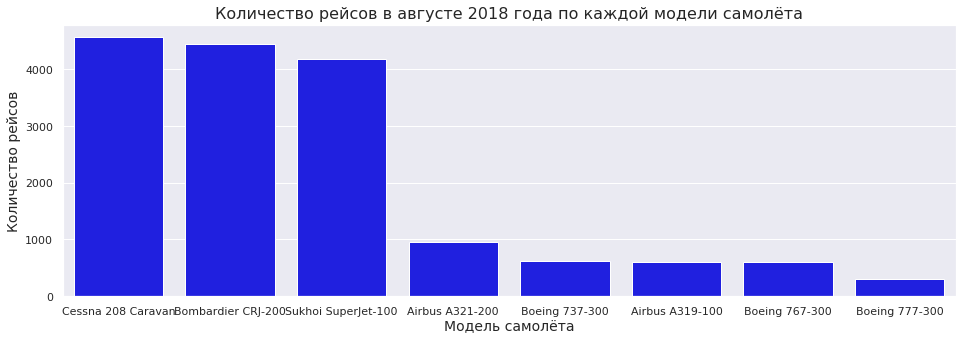

In [19]:
#модели самолетов и количество рейсов
sn.set(rc={'figure.figsize':(16,5)})
query_1 = query_1.sort_values(['flights_amount'],ascending=False)
a = sn.barplot(x="model",y="flights_amount",data=query_1, color='blue')
a.axes.set_title("Количество рейсов в августе 2018 года по каждой модели самолёта", fontsize=16)
a.set_xlabel("Модель самолёта", fontsize=14)
a.set_ylabel("Количество рейсов", fontsize=14);
plt.show()

Больше всего рейсов было совершено на небольших самолётах (Bombardier CRJ-200 и Cessna 208 Caravan), а также Sukhoi SuperJet-100.

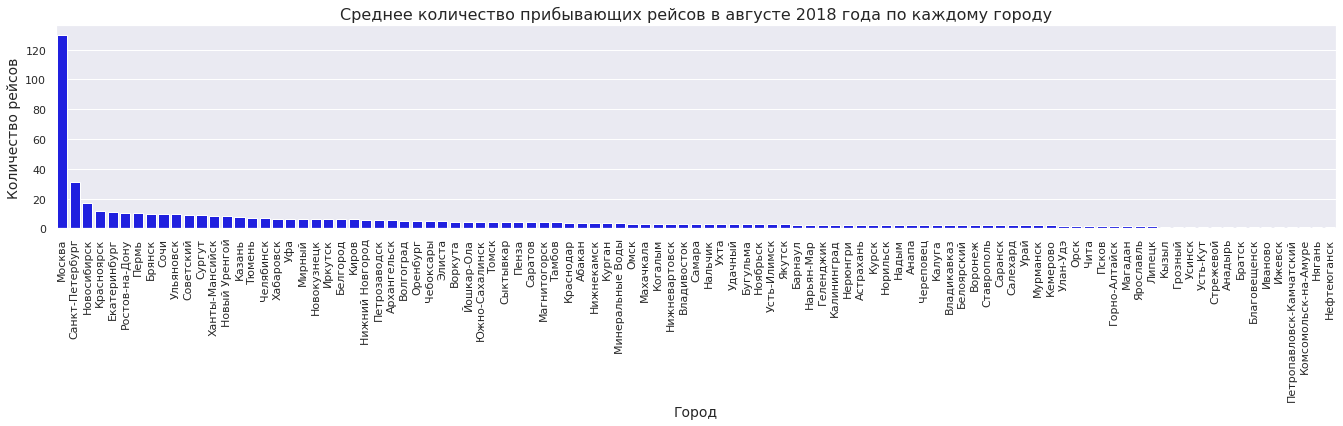

In [27]:
#города и количество рейсов
query_3 = query_3.sort_values(['average_flights'],ascending=False)
sn.set(rc={'figure.figsize':(19,6)})
a = sn.barplot(y="average_flights",x="city",data=query_3, color='blue')
a.axes.set_title("Среднее количество прибывающих рейсов в августе 2018 года по каждому городу", fontsize=16)
a.set_xlabel("Город", fontsize=14)
a.set_ylabel("Количество рейсов", fontsize=14);
plt.xticks(rotation=70)
plt.tight_layout()
plt.xticks(rotation = 90)
plt.show()

Из графика видно, что количество рейстов в Москву намного больше, чем в другие города. 

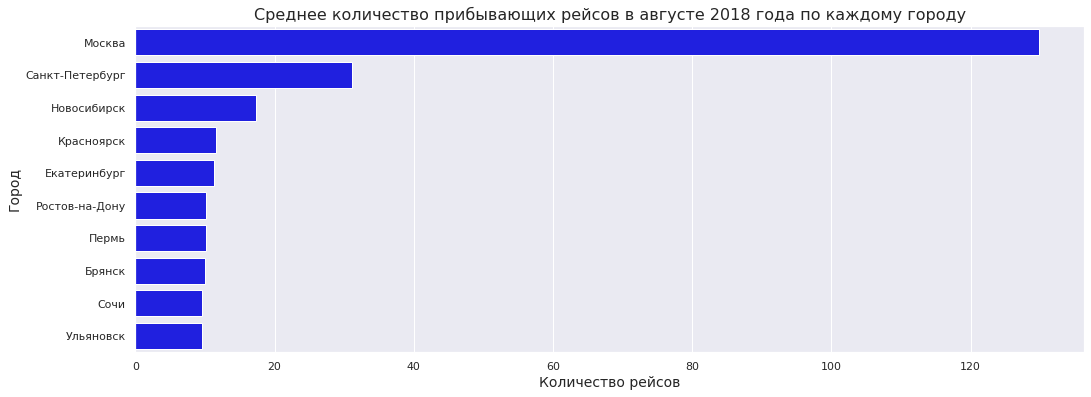

In [22]:
#топ-10 городов и количество рейсов
sn.set(rc={'figure.figsize':(17,6)})
a = sn.barplot(y="city",x="average_flights",data=top, color='blue')
a.axes.set_title("Среднее количество прибывающих рейсов в августе 2018 года по каждому городу", fontsize=16)
a.set_xlabel("Количество рейсов", fontsize=14)
a.set_ylabel("Город", fontsize=14);
plt.show()

Количество рейсов в Москву намного выше, чем в другие города. На втором месте Санк-Петербург, на третьем - Новосибирск. В остальные города из Топ-10 летает примерно одинаковое количество рейсов в день.

# Вывод

Изучив исходные данные и построив графики, я сделала вывод, что больше всего рейсов в августе было совершено в Москву. Больше всего в этом месяце летали на небольших самолётах (Bombardier CRJ-200 и Cessna 208 Caravan), а также Sukhoi SuperJet-100.